# Python Machine Learning: Classification

A common task in computational research is to classify an object based on a set of features. In supervised machine learning, we can give an algorithm a dataset of training examples that say "here are specific features, and this is the target class it belongs to". With enough training examples, a model can be built that recognizes important features in determining an object's class. This model can then be used to predict the class of an object given its known features.


First let's import the packages that we need for this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Penguin Data

Let's say that we are studying penguins in Antartica. We have a set of penguins that we have body measurements for, of three different species: Adelie, Chinstrap, and Gentoo. We are interested in being able to differentiate between these three species based on the measurements. First, let's take a look at our data set. 


Now, let's load in our preprocessed `penguins` data set.  


In [2]:
X_train = pd.read_csv('../data/penguins_X_train.csv')
X_test = pd.read_csv('../data/penguins_X_test.csv')
y_train = pd.read_csv('../data/penguins_y_train.csv')
y_test = pd.read_csv('../data/penguins_y_test.csv')

Let's start with just two penguin species: Adelie and Gentoo. 

In [3]:
X_train = X_train[y_train['species'].isin(['Adelie','Gentoo'])].reset_index()
X_test = X_test[y_test['species'].isin(['Adelie','Gentoo'])].reset_index()
y_train = y_train[y_train['species'].isin(['Adelie','Gentoo'])].reset_index()
y_test = y_test[y_test['species'].isin(['Adelie','Gentoo'])].reset_index()

In [4]:
X_train

,index,Dream,Torgersen,Male,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,1,0.0,0.0,0.0,0.192906,-1.362855,0.983988,1.015651
1,2,0.0,0.0,0.0,0.297821,-1.673616,0.913582,0.271015
2,4,0.0,1.0,0.0,-1.678078,0.657091,-1.198600,-1.063125
3,5,1.0,0.0,0.0,-2.080252,-0.844920,-0.916975,-1.404417
4,6,0.0,0.0,0.0,-0.768815,1.848341,-0.705757,-0.349516
...,...,...,...,...,...,...,...,...
193,242,0.0,0.0,0.0,0.192906,-1.362855,0.420740,1.077704
194,243,0.0,0.0,1.0,0.909825,-1.000301,1.406425,2.629029
195,245,0.0,1.0,1.0,-0.436584,0.605297,-0.424133,0.146909
196,246,0.0,1.0,0.0,-0.646414,0.449917,-0.424133,-1.156205


## Null Accuracy

Let's say that we wanted to assign a species to each unknown measured penguin. One way to do this is to assign all observations to the majority classes. The code below shows the proportion of each species in the training data.

**Question:** If we want to maximize accuracy, which species label would we assign to all observations? 

In [5]:
y_train.value_counts('species')/sum(y_train.value_counts('species'))

species
Adelie    0.550505
Gentoo    0.449495
dtype: float64

This accuracy is our **baseline model**, and is the number that we will try to improve on with classification.

Let's get to know our dataset by conducting some exploratory data analysis. We'll be using some rudimentary data analysis to see there's a relationship between the independent variables across species.

Let's say that we decide that body mass might be a good way to differentiate between Adelie and Gentoo penguins. We can look at a plot of the histogram to see how the distribution of this variable changes between species.

**Question**: Where would you place a line to minimize the overlap in the distribution? 

<AxesSubplot:xlabel='body_mass_g', ylabel='Count'>

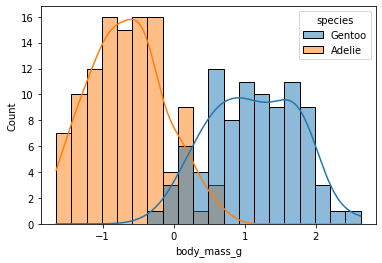

In [6]:
sb.histplot(data=X_train.loc[y_train['species'].isin(['Adelie','Gentoo'])],
                x = 'body_mass_g',
                hue = y_train['species'],kde=True,bins=20)
# plt.axvline(.28,color= 'red')

Now let's apply this same decision boundary to the test data. 

**Question:** Is this still the best boundary?

<AxesSubplot:xlabel='body_mass_g', ylabel='Count'>

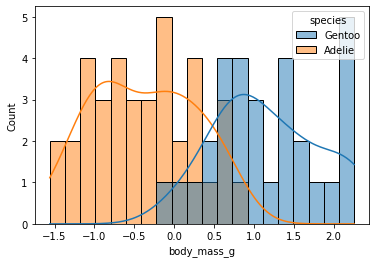

In [7]:
sb.histplot(data=X_test.loc[y_test['species'].isin(['Gentoo','Adelie'])],
                x = 'body_mass_g',
                hue = y_test['species'],kde=True,bins=20)
#plt.axvline(.28,color= 'red')

This is the basic goal of classification. Based on your boundary criteria, you would **classify** all each of the penguins. However there would be some error involved. We can be more confident in our classification at the far ends of the distribution, and less confident where the distributions overlap. 


Now let's figure out how to separate out these groups mathematically. For this, we will start by using an algorithm called Logistic Regression.

## Logistic Regression

Logistic regression is a supervised classification algorithm that is used to predict a binary outcome. Similar to linear regression, this model uses coefficients or betas to make its predictions. However unlike a linear regression, its predictions range from 0 to 1, where 0 and 1 stand for 'confidently class A and B' respectively. Predictions along the middle of the line show less confidence in the prediction.

The function for the logistic regression is:
$$ p(x) = \frac{1}{1 + e^{(-\beta_0+\beta_1x_1...)}}$$

where $\beta$ are the learned parameters and $x$ are the input features.


Let's train a logistic regression model on the variable: `body_mass_g`

### Modeling with Logistic Regression


Logistic regression uses the same general steps as many other `sklearn` algorithms:
1. Initialize Model
2. Fit model on training data
3. Evaluate on training and testing datasets

In [8]:
#1) Initialize Model
lr = LogisticRegression(max_iter=170)

#2) Fit model
lr.fit(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])

#3) Evaluate 
train_score = lr.score(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])
test_score = lr.score(X_test['body_mass_g'].values.reshape(-1, 1), y_test['species'])

print("Training score:", train_score.round(3), "Testing score:", test_score.round(3))

Training score: 0.944 Testing score: 0.836


**Question:** How well did the model do compared to baseline?

## Multivariate Logistic Regression


The logistic regression did a pretty good job at classifying the penguins. However, we have more than just body mass to base our decision of species based on. For example, let's look at the combination of culmen depth and body mass in our data by using a scatterplot.

In the two dimensional space, the intuition is that we want to draw a line that separates the classes. 

**Question:** Is it possible to draw a line that separates the groups? If it is, this is a **linearly seperable** problem

<AxesSubplot:xlabel='culmen_depth_mm', ylabel='body_mass_g'>

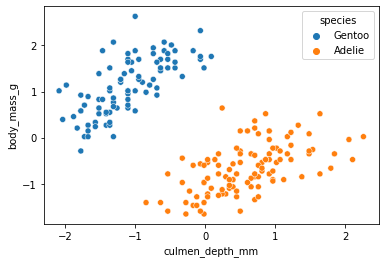

In [9]:
sb.scatterplot(data=X_train.loc[y_train['species'].isin(['Adelie','Gentoo'])],
                x = 'culmen_depth_mm',
                y = 'body_mass_g',
                hue = y_train['species'])

Let's retrain the logistic model with two variables.

In [10]:
lr = LogisticRegression(max_iter=170)
lr.fit(X_train[['body_mass_g','culmen_depth_mm']], y_train['species'])

train_score = lr.score(X_train[['body_mass_g','culmen_depth_mm']], y_train['species'])
test_score = lr.score(X_test[['body_mass_g','culmen_depth_mm']], y_test['species'])

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 1.0, testing score = 1.0


While this doesn't happen often in real life, we got a perfect score! We could add more features to the model, but there isn't a need since our model is already behaving perfectly. Now let's take a look at the coefficients of the model. We reference the `lr.coef_` attribute to see the coefficients

In [11]:

coef = pd.Series(index=['body_mass_g','culmen_depth_mm'], data=lr.coef_[0])

coef.sort_values()

culmen_depth_mm   -2.671132
body_mass_g        2.509731
dtype: float64

**Question:** What do you think the *magnitude* and *sign* of the coefficients means about how these variables are related to each category?
**Hint:** Refer back to the scatter plot!

## Model evaluation

We've covered accuracy already but there a whole litany of other ways to evaluate the performance of a classification model.

In a binary classification task, there are four major types of predictions:

[Confusion Matrix (Wikipedia)](https://en.wikipedia.org/wiki/Confusion_matrix): 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result which wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result which wrongly indicates that a particular condition or attribute is absent


Accuracy, which is the most common metric used with classification can be characterized as:

$$ Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

We can combine the prediction measures above to create three helpful metrics for evaluating classification: **precision**, **recall**, and **specificity**. 


1. **Precision**: 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$


Let's make a confusion matrix and derive the recall and precision scores.

First, let's go back to the original (not perfect) model so we can see what these rates look like.

First we will retrain the model and make predictions on the test set.

In [12]:
lr.fit(X_train['body_mass_g'].values.reshape(-1, 1), y_train['species'])
preds = lr.predict(X_test[['body_mass_g']])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [13]:
# Pass y_test and preds into confusion_matrix
confusion_matrix(y_test['species'], preds)

array([[28,  9],
       [ 2, 28]])

## Challenge 1: Model Evaluation

1). What are the TP, FP, TN, FN in these model results?

2). What is the precision and recall for this model?

3). Which is more important, precision or recall?

Depending on your task, other metrics than accuracy might be more beneficial to understanding your model's performance. At the very least, examining the confusion matrix is a great way to get a better sense of how your model is performing across classes.

## Decision Trees

Let's now include all three species of penguin that we want to differentiate between. We can turn to other models that can handle two or more classes for classification. One such example is the Decision Tree Classifier. In terms of logic, this is like a flow chart.


In this flow chart the data is that the lamp doesn't work, and the features are information about how the lamp doesn't work. The classes is the action that is taken at the end.

![Alt](https://upload.wikimedia.org/wikipedia/commons/9/91/LampFlowchart.svg)

While the ultimate goal of classification remains the same, machine learning algorithms vary widely in terms of *how* they go about this task. The neat thing about `sklearn` is that many algorithms use the same syntax, which makes comparing their performance on a task fairly straightforward. However, each model will have different underlying parameters and methods to identify the optimal split. When you are using a new model it is helpful to read up on how the model works. 

The documentation is a great way to do that.
Read the [documentation](https://scikit-learn.org/stable/modules/tree.html#tree) for the Decision Tree and let's try to answer the following questions:

1). What are two advantages and two disadvantages of the Decision Tree?
2). What measure do Decision Trees use to determine optimal split?
3). How do you import the Decision Tree from sklearn?

**Decision Trees** are a classification/regression supervised learning algorithm that uses a series of splits to make its predictions.

Decision Trees learn from the data by picking the feature-threshold that maximizes the information gain of the target variable. In other words it chooses a splitting point that produces the most imbalanced/pure proportions in the target variable. The goal of the model is to keep splitting until all the data in a terminal node or leaf are exclusively one class.

The model iterates through a set of values for each feature and then calculate the information gain for each split and the one that produces the lowest value is the designated split.

**Parameters**

There are many [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) for the Decision Tree Classifier. A few relevant to this notebook are described here:

**criterion**: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**splitter**: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

**max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split**: The minimum number of samples required to split an internal node

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

**max_features**: The number of features to consider when looking for the best split

Now let's train a decision tree model on the penguins data set. We are going to start with a default DT model, meaning we're not going to pass in any parameters of our own. Like we did before, we are going to fit a model and then evaluate it on the training and testing datasets. Let's start with a single x-feature.

In [14]:
# Initialize model
dt = DecisionTreeClassifier()

# Fit model on the dataset
dt.fit(X_train[['body_mass_g']], y_train['species'])

# Derive the training accuracy score
dt.score(X_train[['body_mass_g']], y_train['species'])

0.9545454545454546

In [15]:
# Test score
dt.score(X_test[['body_mass_g']], y_test['species'])

0.8208955223880597

**Question:** Our testing score is considerably lower. When the testing score is lower than the training score, what does that mean?

We can take advantage of some of the parameters of the decision tree in order to help prevent overfitting of the model. Let's try a model in which we impose some constraints on the tree?

**Question:** From the documentation, what is one parameter that might help?

In [16]:
# Initialize
dt = DecisionTreeClassifier(max_depth=2)
# Fit 
dt.fit(X_train[['body_mass_g']], y_train['species'])

# Evaluate
train_score = dt.score(X_train[['body_mass_g']], y_train['species'])
test_score = dt.score(X_test[['body_mass_g']], y_test['species'])

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.944 and our testing score is 0.836


The gap between the two scores is considerably lower. Arguably we don't have an over fit model anymore. However, we could likely improve on the accuracy of this model by including more features.

### Tree Visualization

One big advantage of the Decision Tree is that it can be visualized no matter how many features were involved.

Let's retrain it with a small `max_depth` 

In [17]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train[['body_mass_g']], y_train['species'])

DecisionTreeClassifier(max_depth=2)

In [31]:
y_train

,index,species
0,1,Gentoo
1,2,Gentoo
2,4,Adelie
3,5,Adelie
4,6,Adelie
...,...,...
193,242,Gentoo
194,243,Gentoo
195,245,Adelie
196,246,Adelie


**Question:** What is the first criteria used to split the decision tree? 

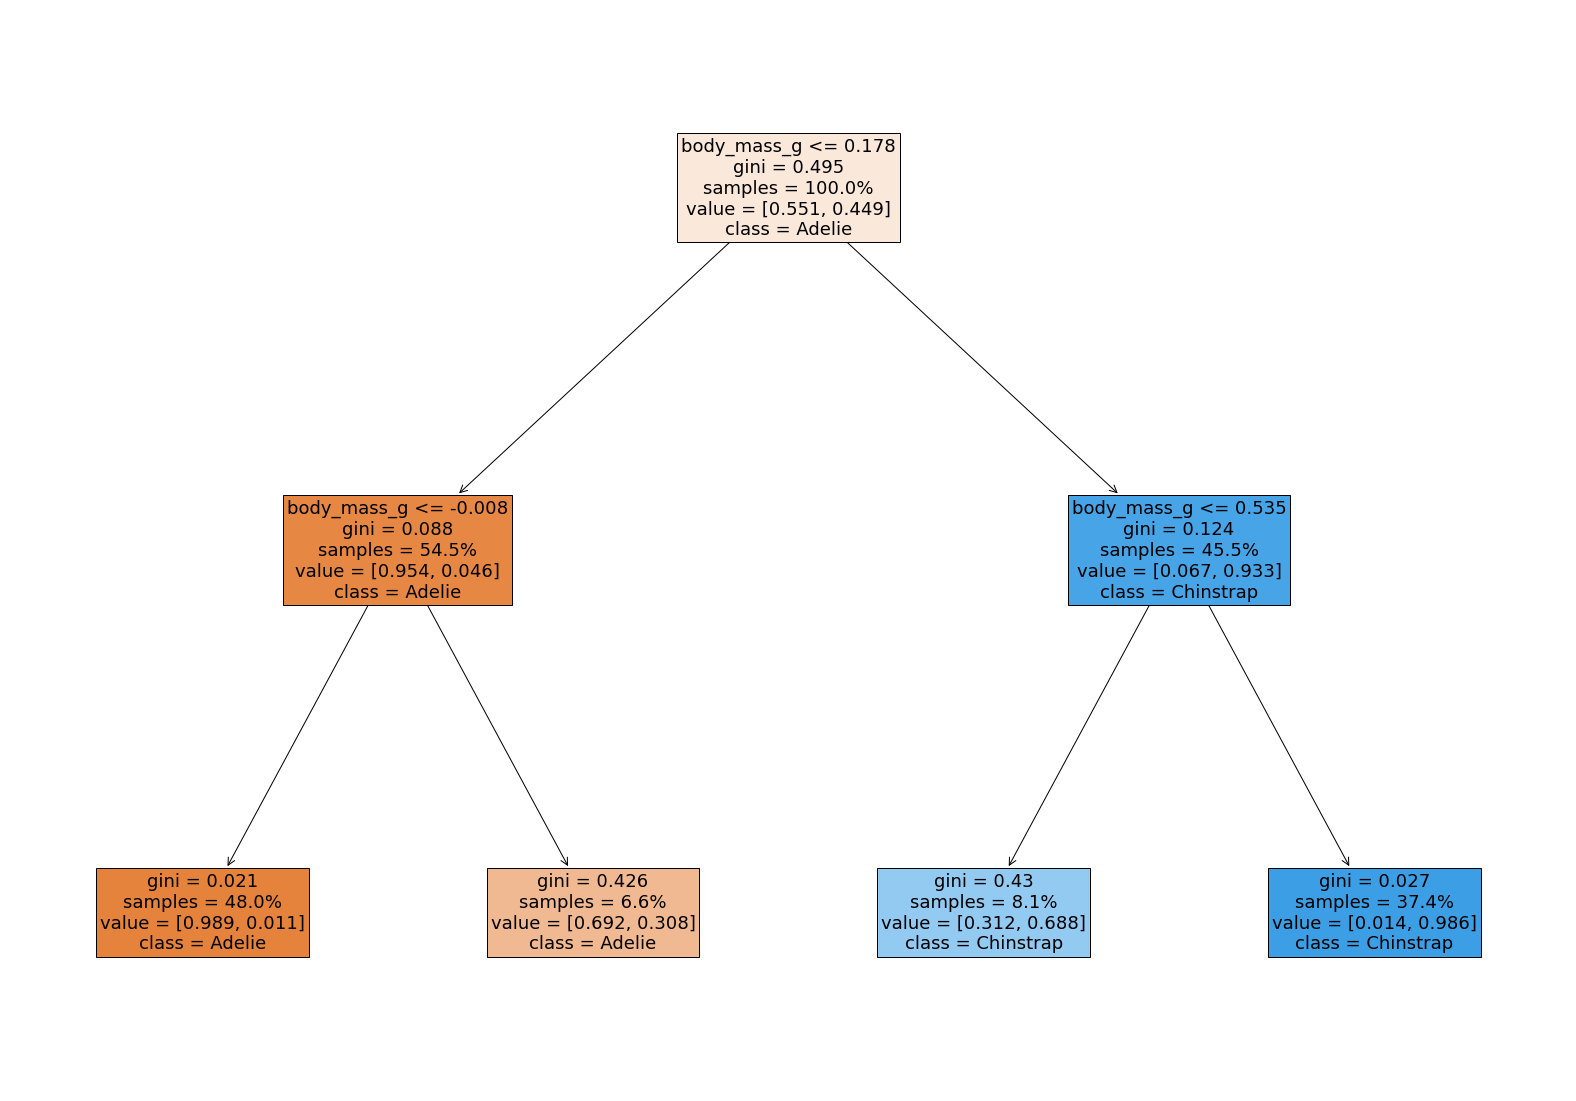

In [18]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=['body_mass_g'], class_names=["Adelie", "Chinstrap","Gentoo"], 
          filled = True, proportion=True, fontsize=18
         );

Using the tree, how would we make predictions about the following customers?


    - Penguin A: Body Mass of .5
    - Penguin B: Body Mass of 0

## Lets fit all parameters to just the three penguins

In [58]:
X_train = pd.read_csv('../data/penguins_X_train.csv')
X_test = pd.read_csv('../data/penguins_X_test.csv')
y_train = pd.read_csv('../data/penguins_y_train.csv')
y_test = pd.read_csv('../data/penguins_y_test.csv')

In [59]:
X_train.columns.tolist()
# y_train

['Dream',
 'Torgersen',
 'Male',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g']

In [60]:
# Initialize model
dt = DecisionTreeClassifier()

# Fit model on the dataset
dt.fit(X_train, y_train)

# Derive the training accuracy score
dt.score(X_train, y_train)

1.0

In [61]:
# Test score
dt.score(X_test, y_test)

0.9880952380952381

In [67]:
# Initialize
dt = DecisionTreeClassifier(max_depth=None)
# Fit 
dt.fit(X_train, y_train)

# Evaluate
train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 1.0 and our testing score is 0.988


In [68]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train['species'])

DecisionTreeClassifier(max_depth=2)

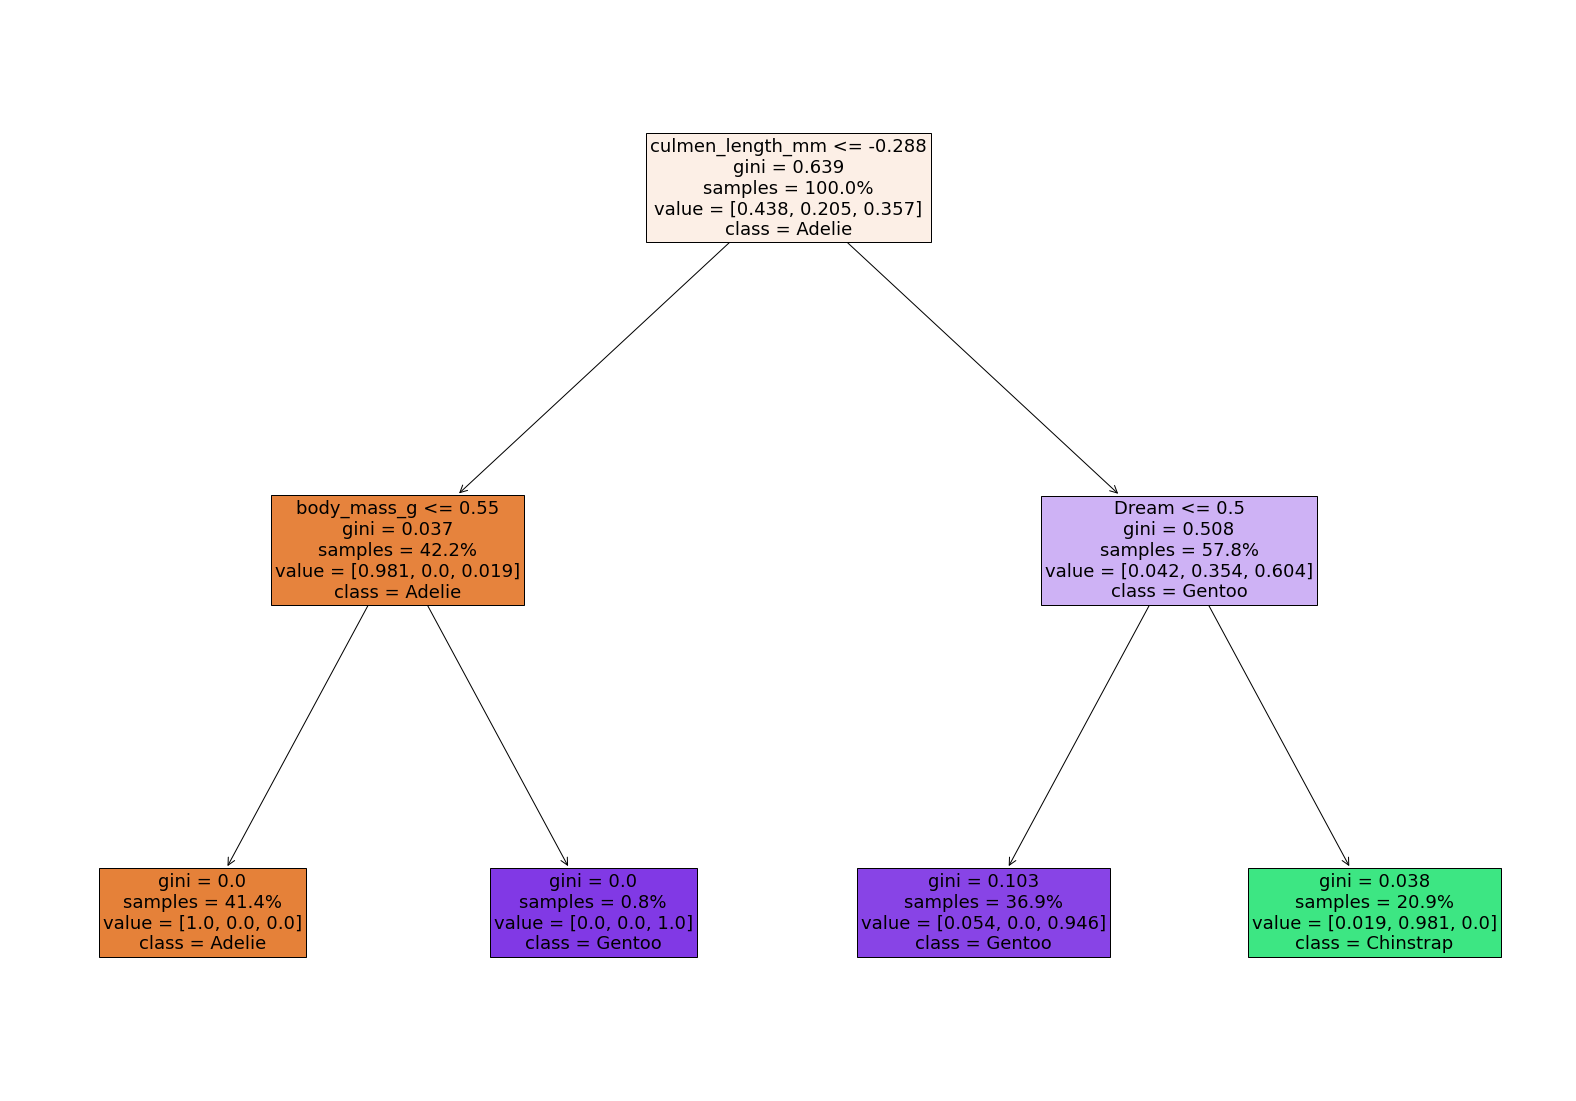

In [69]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=['Dream',
 'Torgersen',
 'Male',
 'culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g'], class_names=["Adelie", "Chinstrap","Gentoo"], 
          filled = True, proportion=True, fontsize=18
         );

## Challenge 2: Classification with SVM

Now let's try another new model. The [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html#classification) is another class of machine learning algorithm that is used for classification. 

Choose two features of the data set to train your model on. Then, using the documentation for the support vector machine, follow the steps to:
- Initialize the model
- Fit it to the training data
- Evaluate the model on both the training and testing data

Is your model underfit? Is it overfit?

How does SVM fit in with the **linearly separable** problem identified in the scatter plots above?

In [30]:
X_train
# y_train.columns.values

,index,Unnamed: 0,Dream,Torgersen,Male,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0,0,1.0,0.0,0.0,-0.936600,0.841269,-0.769935,-0.758116
1,1,1,0.0,1.0,0.0,-1.342735,1.095982,-0.553390,-0.948473
2,2,2,0.0,0.0,1.0,1.574049,-0.788895,1.467688,1.589623
3,4,4,0.0,0.0,1.0,0.429488,-0.687009,1.034600,1.082003
4,5,5,1.0,0.0,1.0,-1.250432,0.484671,-1.636111,-0.377402
...,...,...,...,...,...,...,...,...,...
193,243,243,0.0,0.0,1.0,-0.530466,0.535614,-0.625572,-0.187044
194,244,244,0.0,0.0,1.0,0.946387,-1.094550,1.972957,1.653075
195,245,245,0.0,0.0,0.0,0.466410,-1.196435,1.178962,1.272361
196,247,247,1.0,0.0,1.0,-1.416578,1.197868,-0.769935,-0.504306


In [76]:
## YOUR CODE HERE
from sklearn.svm import SVC
X_train_subset = X_train
X_test_subset = X_test
y_train_subset = y_train
y_test_subset = y_test


In [77]:
##1) Initialize SVM
model = SVC()

##2) Train SVM on Training data 
model.fit(X_train_subset,y_train_subset)
##3) Evaluate SVM on Training and Test Data
model.score(X_train_subset,y_train_subset)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [78]:
model.score(X_test_subset,y_test_subset)

0.9761904761904762